# Introduction
In this notebook we present our code for our capstone project in an easy to read and understandable way.

* ___Say something about the project___

* ___Say something about the notebook structure___

* ___Any additional notes?___

# Setup

* ___Optional: Add subtext to every header___

## Basic setup

In [2]:
# Import libraries
import pandas as pd #pandas is a Python package that provides fast, flexible, and expressive data structures.
import numpy as np #NumPy is an Python library that facilitates efficient numerical operations on large quantities of data.
import sqlalchemy #SQLAlchemy is the Python SQL toolkit and Object Relational Mapper that gives application developers the power and flexibility of SQL.
import psycopg2 # needed to get database exception errors when uploading dataframe
import matplotlib.pyplot as plt # needed for visualizations
import seaborn as sns # data visualization library based on matplotlib
import os # provides functions for interacting with the operating system
import math # provides access to the mathematical functions
import sql_functions as sf # own collection of functions to manage connections to our SQL database
import re #this module provides regular expression matching operations
import math #this module provides access to the mathematical functions
import warnings #the warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception).
warnings.filterwarnings('ignore')


In [3]:
# Define variables
schema = 'capstone_kueblbeck'
engine = sf.get_engine()

In [4]:
# Other settings
pd.options.display.max_columns = 40
pd.options.display.float_format = "{:,.2f}".format

## Prepare data and export to SQL

### Import data from external files

In [5]:
# Import "Lagerbestand"
lagerbestand = pd.read_csv('./data/Lagerbestand_02.Juni.2023.txt', decimal=',')
lagerbestand = lagerbestand.drop(lagerbestand.index[0])

FileNotFoundError: [Errno 2] No such file or directory: './data/Lagerbestand_02.Juni.2023.txt'

In [ ]:
# Import "Lieferanten"
lieferanten = pd.read_excel('./data/Lieferantenübersicht.xlsx')
lieferanten = lieferanten.drop(lieferanten.index[0])

In [ ]:
# Import "Verkäufe"
verkaeufe = pd.read_csv('./data/Abverkauf_DE_2022_8410.csv', decimal=',')
verkaeufe = verkaeufe.drop(verkaeufe.index[0])

/var/folders/kv/8g80w4s52_ldz0hf8y_2jgw40000gn/T/ipykernel_22812/3738684025.py:2: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  verkaeufe = pd.read_csv('./data/Abverkauf_DE_2022_8410.csv', decimal=',')


### Correct datatypes for each table (if necessary)

#### Lagerbestand

In [ ]:
# Change date columns from string to date type
date_columns = ["Ltz. VK ges.", "Ltz. VK WEN", "Ltz. VK RGB", "Ltz. VK AMB", "Ltz. VK CHA", "Ltz. VK STR", "Ltz. VK PAS", "Ltz. VK LAN", "Ltz. VK MÜH", "Ltz. VK ROS"]

for column in date_columns:
        lagerbestand[column] = pd.to_datetime(lagerbestand[column], format='%d.%m.%Y', errors='coerce')

In [ ]:
# Change selected number columns from string to float type
numeric_columns = ['Gesamt', 'WEN', 'RGB', 'AMB', 'CHA', 'STR', 'PAS', 'LAN', 'MÜH', 'ROS']

for column in numeric_columns:
    lagerbestand[column] = pd.to_numeric(lagerbestand[column].str.replace('.', '').str.replace(',','.'), errors='coerce')

/var/folders/kv/8g80w4s52_ldz0hf8y_2jgw40000gn/T/ipykernel_22812/2712846017.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  lagerbestand[column] = pd.to_numeric(lagerbestand[column].str.replace('.', '').str.replace(',','.'), errors='coerce')


In [ ]:
# Special treatment for columns 'Basispreis' and 'Basispr. Summe'
numeric_columns_basis = ['Basispreis', 'Basispr. Summe']

for column in numeric_columns_basis:
    lagerbestand[column] = pd.to_numeric(lagerbestand[column].str.replace('.', '').str.replace(',','.'))

/var/folders/kv/8g80w4s52_ldz0hf8y_2jgw40000gn/T/ipykernel_22812/727319556.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  lagerbestand[column] = pd.to_numeric(lagerbestand[column].str.replace('.', '').str.replace(',','.'))


In [ ]:
# Change 'Lfnr' and 'VPE' to Integer type, as these are categorical numbers
lagerbestand['Lfnr'] = lagerbestand['Lfnr'].astype(int)
lagerbestand['VPE'] = lagerbestand['VPE'].astype(int)

#### Lieferanten

In [ ]:
# Sync datatype in column 'Lfnr' to table 'Lagerbestand'
lieferanten['Lfnr'] = lieferanten['Lfnr'].astype(int)

#### Verkaeufe

In [ ]:
# Change selected number columns from string to float type
numeric_columns = ["Gesamt", "WEN", "RGB", "AMB", "CHA", "STR", "PAS", "LAN", "MÜH", "ROS"]

for column in numeric_columns:
    verkaeufe[column] = pd.to_numeric(verkaeufe[column].str.replace('.', ''), errors='coerce')

/var/folders/kv/8g80w4s52_ldz0hf8y_2jgw40000gn/T/ipykernel_22812/1413186216.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  verkaeufe[column] = pd.to_numeric(verkaeufe[column].str.replace('.', ''), errors='coerce')


In [ ]:
# Sync datatype in column 'Lfr.' to table 'Lagerbestand'
verkaeufe['Lfr.'] = verkaeufe['Lfr.'].astype(int)

#### Check Dataframes before Export

In [ ]:
display(lagerbestand.head(2))
display(lagerbestand.info())

,Lfnr,Artnr,Index,Beschr.,BKZ,VPE,St.gr.,Ltz. VK ges.,Basispreis,Basispr. Summe,Gesamt,WEN,Ltz. VK WEN,RGB,Ltz. VK RGB,AMB,Ltz. VK AMB,CHA,Ltz. VK CHA,STR,Ltz. VK STR,PAS,Ltz. VK PAS,LAN,Ltz. VK LAN,MÜH,Ltz. VK MÜH,ROS,Ltz. VK ROS
1,430,08.607.83,000,"N CORSA D 1,0L 44KW BJ 2006",8,1,L20,2018-11-07,75.36,0.00,0.00,0.00,NaT,0.00,2018-11-07,0.00,2017-08-08,0.00,2016-04-29,0.00,2017-12-14,0.00,NaT,0.00,2017-08-31,0.00,NaT,0.00,2014-03-26
2,430,08.607.81,000,"M CORSA D 1,4L 66KW BJ 2006",8,1,L20,2021-08-04,93.63,0.00,0.00,0.00,2021-08-04,0.00,2017-07-10,0.00,2021-04-26,0.00,2021-04-28,0.00,2018-09-13,0.00,2019-07-31,0.00,2016-06-24,0.00,NaT,0.00,2015-05-04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357829 entries, 1 to 357829
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Lfnr            357829 non-null  int64         
 1   Artnr           357829 non-null  object        
 2   Index           357829 non-null  object        
 3   Beschr.         357829 non-null  object        
 4   BKZ             357829 non-null  object        
 5   VPE             357829 non-null  int64         
 6   St.gr.          357829 non-null  object        
 7   Ltz. VK ges.    338128 non-null  datetime64[ns]
 8   Basispreis      357829 non-null  float64       
 9   Basispr. Summe  357829 non-null  float64       
 10  Gesamt          325061 non-null  float64       
 11  WEN             325061 non-null  float64       
 12  Ltz. VK WEN     204992 non-null  datetime64[ns]
 13  RGB             98303 non-null   float64       
 14  Ltz. VK RGB     124822 non-null  dat

None

In [ ]:
display(lieferanten.head(2))
display(lieferanten.info())

,Lfnr,Beschreibung
1,0,BOSCH
2,1,HELLA


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 1 to 378
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Lfnr          378 non-null    int64 
 1   Beschreibung  376 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


None

In [ ]:
display(verkaeufe.head(2))
display(verkaeufe.info())

,Lfr.,Art.nr.,Ind.,Beschreibung,Gesamt,WEN,RGB,STR,PAS,AMB,CHA,LAN,MÜH,ROS
1,0,1928498680,0.00,BUCHSENKONTAKT,"38,400.00","38,400.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,52,50266496,0.00,"KABELBAND 300X4,8MM SCHWARZ","28,200.00","25,000.00",0.00,0.00,0.00,0.00,"1,400.00",0.00,"1,500.00",300.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66009 entries, 1 to 66009
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lfr.          66009 non-null  int64  
 1   Art.nr.       66009 non-null  object 
 2   Ind.          66009 non-null  float64
 3   Beschreibung  66009 non-null  object 
 4   Gesamt        65535 non-null  float64
 5   WEN           65535 non-null  float64
 6   RGB           65535 non-null  float64
 7   STR           65535 non-null  float64
 8   PAS           65535 non-null  float64
 9   AMB           65535 non-null  float64
 10  CHA           65535 non-null  float64
 11  LAN           65535 non-null  float64
 12  MÜH           65535 non-null  float64
 13  ROS           65535 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 7.1+ MB


None

### Export to SQL

Note: The following code blocks will be fully commented out as the dataframes are already uploaded. Running these codes would therefore cause an error due to restrictions on our SQL server.

In [ ]:
# # Import Lagerbestand data into SQL 
# table_name = 'lagerbestand'

# # Write records stored in a dataframe to SQL database
# if engine!=None:
#     try:
#         lagerbestand.to_sql(name=table_name, # Name of SQL table
#                         con=engine, # Engine or connection
#                         if_exists='replace', # Drop the table before inserting new values 
#                         schema=schema, # Use schema that was defined earlier
#                         index=False, # Write DataFrame index as a column
#                         chunksize=5000, # Specify the number of rows in each batch to be written at a time
#                         method='multi') # Pass multiple values in a single INSERT clause
#         print(f"The {table_name} table was imported successfully.")
#     # Error handling
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         engine = None

In [ ]:
# # Import 'Lieferanten' data into SQL 
# table_name = 'lieferanten'

# # Write records stored in a dataframe to SQL database
# if engine!=None:
#     try:
#         lieferanten.to_sql(name=table_name, # Name of SQL table
#                         con=engine, # Engine or connection
#                         if_exists='replace', # Drop the table before inserting new values 
#                         schema=schema, # Use schema that was defined earlier
#                         index=False, # Write DataFrame index as a column
#                         chunksize=5000, # Specify the number of rows in each batch to be written at a time
#                         method='multi') # Pass multiple values in a single INSERT clause
#         print(f"The {table_name} table was imported successfully.")
#     # Error handling
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         engine = None

In [ ]:
# # Import 'Verkaeufe' data into SQL 
# table_name = 'verkäufe'

# # Write records stored in a dataframe to SQL database
# if engine!=None:
#     try:
#         verkaeufe.to_sql(name=table_name, # Name of SQL table
#                         con=engine, # Engine or connection
#                         if_exists='replace', # Drop the table before inserting new values 
#                         schema=schema, # Use schema that was defined earlier
#                         index=False, # Write DataFrame index as a column
#                         chunksize=5000, # Specify the number of rows in each batch to be written at a time
#                         method='multi') # Pass multiple values in a single INSERT clause
#         print(f"The {table_name} table was imported successfully.")
#     # Error handling
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         engine = None

# Data Cleaning

## Loading dataframes

In [ ]:
# Lagerbestand
sql_query = f'select * from {schema}.lagerbestand'
df_lagerbestand = sf.get_dataframe(sql_query)

In [ ]:
# Lieferanten
sql_query = f'select * from {schema}.lieferanten'
df_lieferanten = sf.get_dataframe(sql_query)

In [ ]:
# Verkaeufe
sql_query = f'select * from {schema}.verkäufe'
df_verkaeufe = sf.get_dataframe(sql_query)

## df_lagerbestand

In [ ]:
# Adjust column names
df_lagerbestand.columns = df_lagerbestand.columns.str.lower()
df_lagerbestand.columns = [col.replace(" ", "_") for col in df_lagerbestand.columns.tolist()]
df_lagerbestand.columns = [col.replace(".", "") for col in df_lagerbestand.columns.tolist()]

In [ ]:
# Change names of selected columns for clearer identification
new_columns = {'beschr':'beschreibung',
               'bkz':'bestellkennzeichen',
               'vpe':'verp_einheit',
               'stgr':'stat_gruppe',
               'gesamt':'gesamt_lager',
               'wen':'wen_lager',
               'rgb':'rgb_lager',
               'str':'str_lager',
               'pas':'pas_lager',
               'amb':'amb_lager',
               'cha':'cha_lager',
               'lan':'lan_lager',
               'müh':'müh_lager',
               'ros':'ros_lager'}

df_lagerbestand = df_lagerbestand.rename(columns=new_columns)

In [ ]:
# Additional changing of datatypes for index column (Integer due to it being categorical)
df_lagerbestand['index'] = df_lagerbestand['index'].astype(int)

## df_lieferanten

In [ ]:
# Adjust column names
df_lieferanten.columns = df_lieferanten.columns.str.lower()
df_lieferanten.columns = [col.replace(" ", "_") for col in df_lieferanten.columns.tolist()]
df_lieferanten.columns = [col.replace(".", "") for col in df_lieferanten.columns.tolist()]

In [ ]:
# Change names of selected columns for clearer identification
df_lieferanten = df_lieferanten.rename(columns={'beschreibung':'lieferant'})

## df_verkaeufe

In [ ]:
# Adjust column names
df_verkaeufe.columns = df_verkaeufe.columns.str.lower()
df_verkaeufe.columns = [col.replace(" ", "_") for col in df_verkaeufe.columns.tolist()]
df_verkaeufe.columns = [col.replace(".", "") for col in df_verkaeufe.columns.tolist()]

In [ ]:
# Change names of selected columns for clearer identification
new_columns = {'lfr':'lfnr',
               'ind': 'index',
               'gesamt':'gesamt_vk',
               'wen':'wen_vk',
               'rgb':'rgb_vk',
               'str':'str_vk',
               'pas':'pas_vk',
               'amb':'amb_vk',
               'cha':'cha_vk',
               'lan':'lan_vk',
               'müh':'müh_vk',
               'ros':'ros_vk'}

df_verkaeufe = df_verkaeufe.rename(columns=new_columns)

In [ ]:
# Additional changing of datatypes for index column (Integer due to it being categorical)
df_verkaeufe['index'] = df_verkaeufe['index'].astype(int)

## Check dataframes

In [ ]:
display(df_lagerbestand.head(2))
display(df_lagerbestand.info())

,lfnr,artnr,index,beschreibung,bestellkennzeichen,verp_einheit,stat_gruppe,ltz_vk_ges,basispreis,basispr_summe,gesamt_lager,wen_lager,ltz_vk_wen,rgb_lager,ltz_vk_rgb,amb_lager,ltz_vk_amb,cha_lager,ltz_vk_cha,str_lager,ltz_vk_str,pas_lager,ltz_vk_pas,lan_lager,ltz_vk_lan,müh_lager,ltz_vk_müh,ros_lager,ltz_vk_ros
0,430,08.607.83,0,"N CORSA D 1,0L 44KW BJ 2006",8,1,L20,2018-11-07,75.36,0.00,0,0,NaT,0,2018-11-07,0,2017-08-08,0,2016-04-29,0,2017-12-14,0,NaT,0,2017-08-31,0,NaT,0,2014-03-26
1,430,08.607.81,0,"M CORSA D 1,4L 66KW BJ 2006",8,1,L20,2021-08-04,93.63,0.00,0,0,2021-08-04,0,2017-07-10,0,2021-04-26,0,2021-04-28,0,2018-09-13,0,2019-07-31,0,2016-06-24,0,NaT,0,2015-05-04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357829 entries, 0 to 357828
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   lfnr                357829 non-null  object        
 1   artnr               357829 non-null  object        
 2   index               357829 non-null  int64         
 3   beschreibung        357829 non-null  object        
 4   bestellkennzeichen  357829 non-null  object        
 5   verp_einheit        357829 non-null  object        
 6   stat_gruppe         357829 non-null  object        
 7   ltz_vk_ges          338128 non-null  datetime64[ns]
 8   basispreis          357829 non-null  float64       
 9   basispr_summe       357829 non-null  float64       
 10  gesamt_lager        357829 non-null  int64         
 11  wen_lager           357829 non-null  int64         
 12  ltz_vk_wen          204992 non-null  datetime64[ns]
 13  rgb_lager           357829 no

None

In [ ]:
display(df_lieferanten.head(2))
display(df_lieferanten.info())

,lfnr,lieferant
0,0,BOSCH
1,1,HELLA


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lfnr       378 non-null    object
 1   lieferant  376 non-null    object
dtypes: object(2)
memory usage: 6.0+ KB


None

In [ ]:
display(df_verkaeufe.head(2))
display(df_verkaeufe.info())

,lfnr,artnr,index,beschreibung,wawi_artikeleinstandspreis_(fest),gesamt_vk,wen_vk,rgb_vk,str_vk,pas_vk,amb_vk,cha_vk,lan_vk,müh_vk,ros_vk
0,0,1928498680,0,BUCHSENKONTAKT,0.17,38400,38400,0,0,0,0,0,0,0,0
1,52,50266496,0,"KABELBAND 300X4,8MM SCHWARZ",0.05,28200,25000,0,0,0,0,1400,0,1500,300


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66010 entries, 0 to 66009
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   lfnr                               66010 non-null  object 
 1   artnr                              66010 non-null  object 
 2   index                              66010 non-null  int64  
 3   beschreibung                       66010 non-null  object 
 4   wawi_artikeleinstandspreis_(fest)  66010 non-null  float64
 5   gesamt_vk                          66010 non-null  int64  
 6   wen_vk                             66010 non-null  int64  
 7   rgb_vk                             66010 non-null  int64  
 8   str_vk                             66010 non-null  int64  
 9   pas_vk                             66010 non-null  int64  
 10  amb_vk                             66010 non-null  int64  
 11  cha_vk                             66010 non-null  int

None

# Merging tables to df_master

In [ ]:
# Merging df_lagerbestand and df_lieferanten
df_master = df_lagerbestand.merge(df_lieferanten, how='left', on='lfnr')

In [ ]:
# Merging df_verkaeufe on df_master
df_master = df_master.merge(df_verkaeufe, how='left', on=['lfnr', 'artnr', 'index', 'beschreibung'])

In [ ]:
# Adjusting column positions
new_column_order = ['lfnr','lieferant', 'artnr', 'beschreibung', 'index', 'bestellkennzeichen',
       'verp_einheit', 'stat_gruppe', 'ltz_vk_ges', 'basispreis',
       'basispr_summe', 'gesamt_lager', 'wen_lager', 'ltz_vk_wen', 'rgb_lager',
       'ltz_vk_rgb', 'amb_lager', 'ltz_vk_amb', 'cha_lager', 'ltz_vk_cha',
       'str_lager', 'ltz_vk_str', 'pas_lager', 'ltz_vk_pas', 'lan_lager',
       'ltz_vk_lan', 'müh_lager', 'ltz_vk_müh', 'ros_lager', 'ltz_vk_ros',
        'gesamt_vk', 'wen_vk', 'rgb_vk', 'str_vk', 'pas_vk',
       'amb_vk', 'cha_vk', 'lan_vk', 'müh_vk', 'ros_vk']

df_master = df_master.reindex(columns = new_column_order)

## Check df_master

In [ ]:
display(df_master.head(2))
display(df_master.info())

,lfnr,lieferant,artnr,beschreibung,index,bestellkennzeichen,verp_einheit,stat_gruppe,ltz_vk_ges,basispreis,basispr_summe,gesamt_lager,wen_lager,ltz_vk_wen,rgb_lager,ltz_vk_rgb,amb_lager,ltz_vk_amb,cha_lager,ltz_vk_cha,str_lager,ltz_vk_str,pas_lager,ltz_vk_pas,lan_lager,ltz_vk_lan,müh_lager,ltz_vk_müh,ros_lager,ltz_vk_ros,gesamt_vk,wen_vk,rgb_vk,str_vk,pas_vk,amb_vk,cha_vk,lan_vk,müh_vk,ros_vk
0,430,Eberspächer Abgas,08.607.83,"N CORSA D 1,0L 44KW BJ 2006",0,8,1,L20,2018-11-07,75.36,0.00,0,0,NaT,0,2018-11-07,0,2017-08-08,0,2016-04-29,0,2017-12-14,0,NaT,0,2017-08-31,0,NaT,0,2014-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,430,Eberspächer Abgas,08.607.81,"M CORSA D 1,4L 66KW BJ 2006",0,8,1,L20,2021-08-04,93.63,0.00,0,0,2021-08-04,0,2017-07-10,0,2021-04-26,0,2021-04-28,0,2018-09-13,0,2019-07-31,0,2016-06-24,0,NaT,0,2015-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 357830 entries, 0 to 357829
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   lfnr                357830 non-null  object        
 1   lieferant           357829 non-null  object        
 2   artnr               357830 non-null  object        
 3   beschreibung        357830 non-null  object        
 4   index               357830 non-null  int64         
 5   bestellkennzeichen  357830 non-null  object        
 6   verp_einheit        357830 non-null  object        
 7   stat_gruppe         357830 non-null  object        
 8   ltz_vk_ges          338129 non-null  datetime64[ns]
 9   basispreis          357830 non-null  float64       
 10  basispr_summe       357830 non-null  float64       
 11  gesamt_lager        357830 non-null  int64         
 12  wen_lager           357830 non-null  int64         
 13  ltz_vk_wen          204992 no

None

# Creating visualizations

## Visualize quality stock

KeyboardInterrupt: 

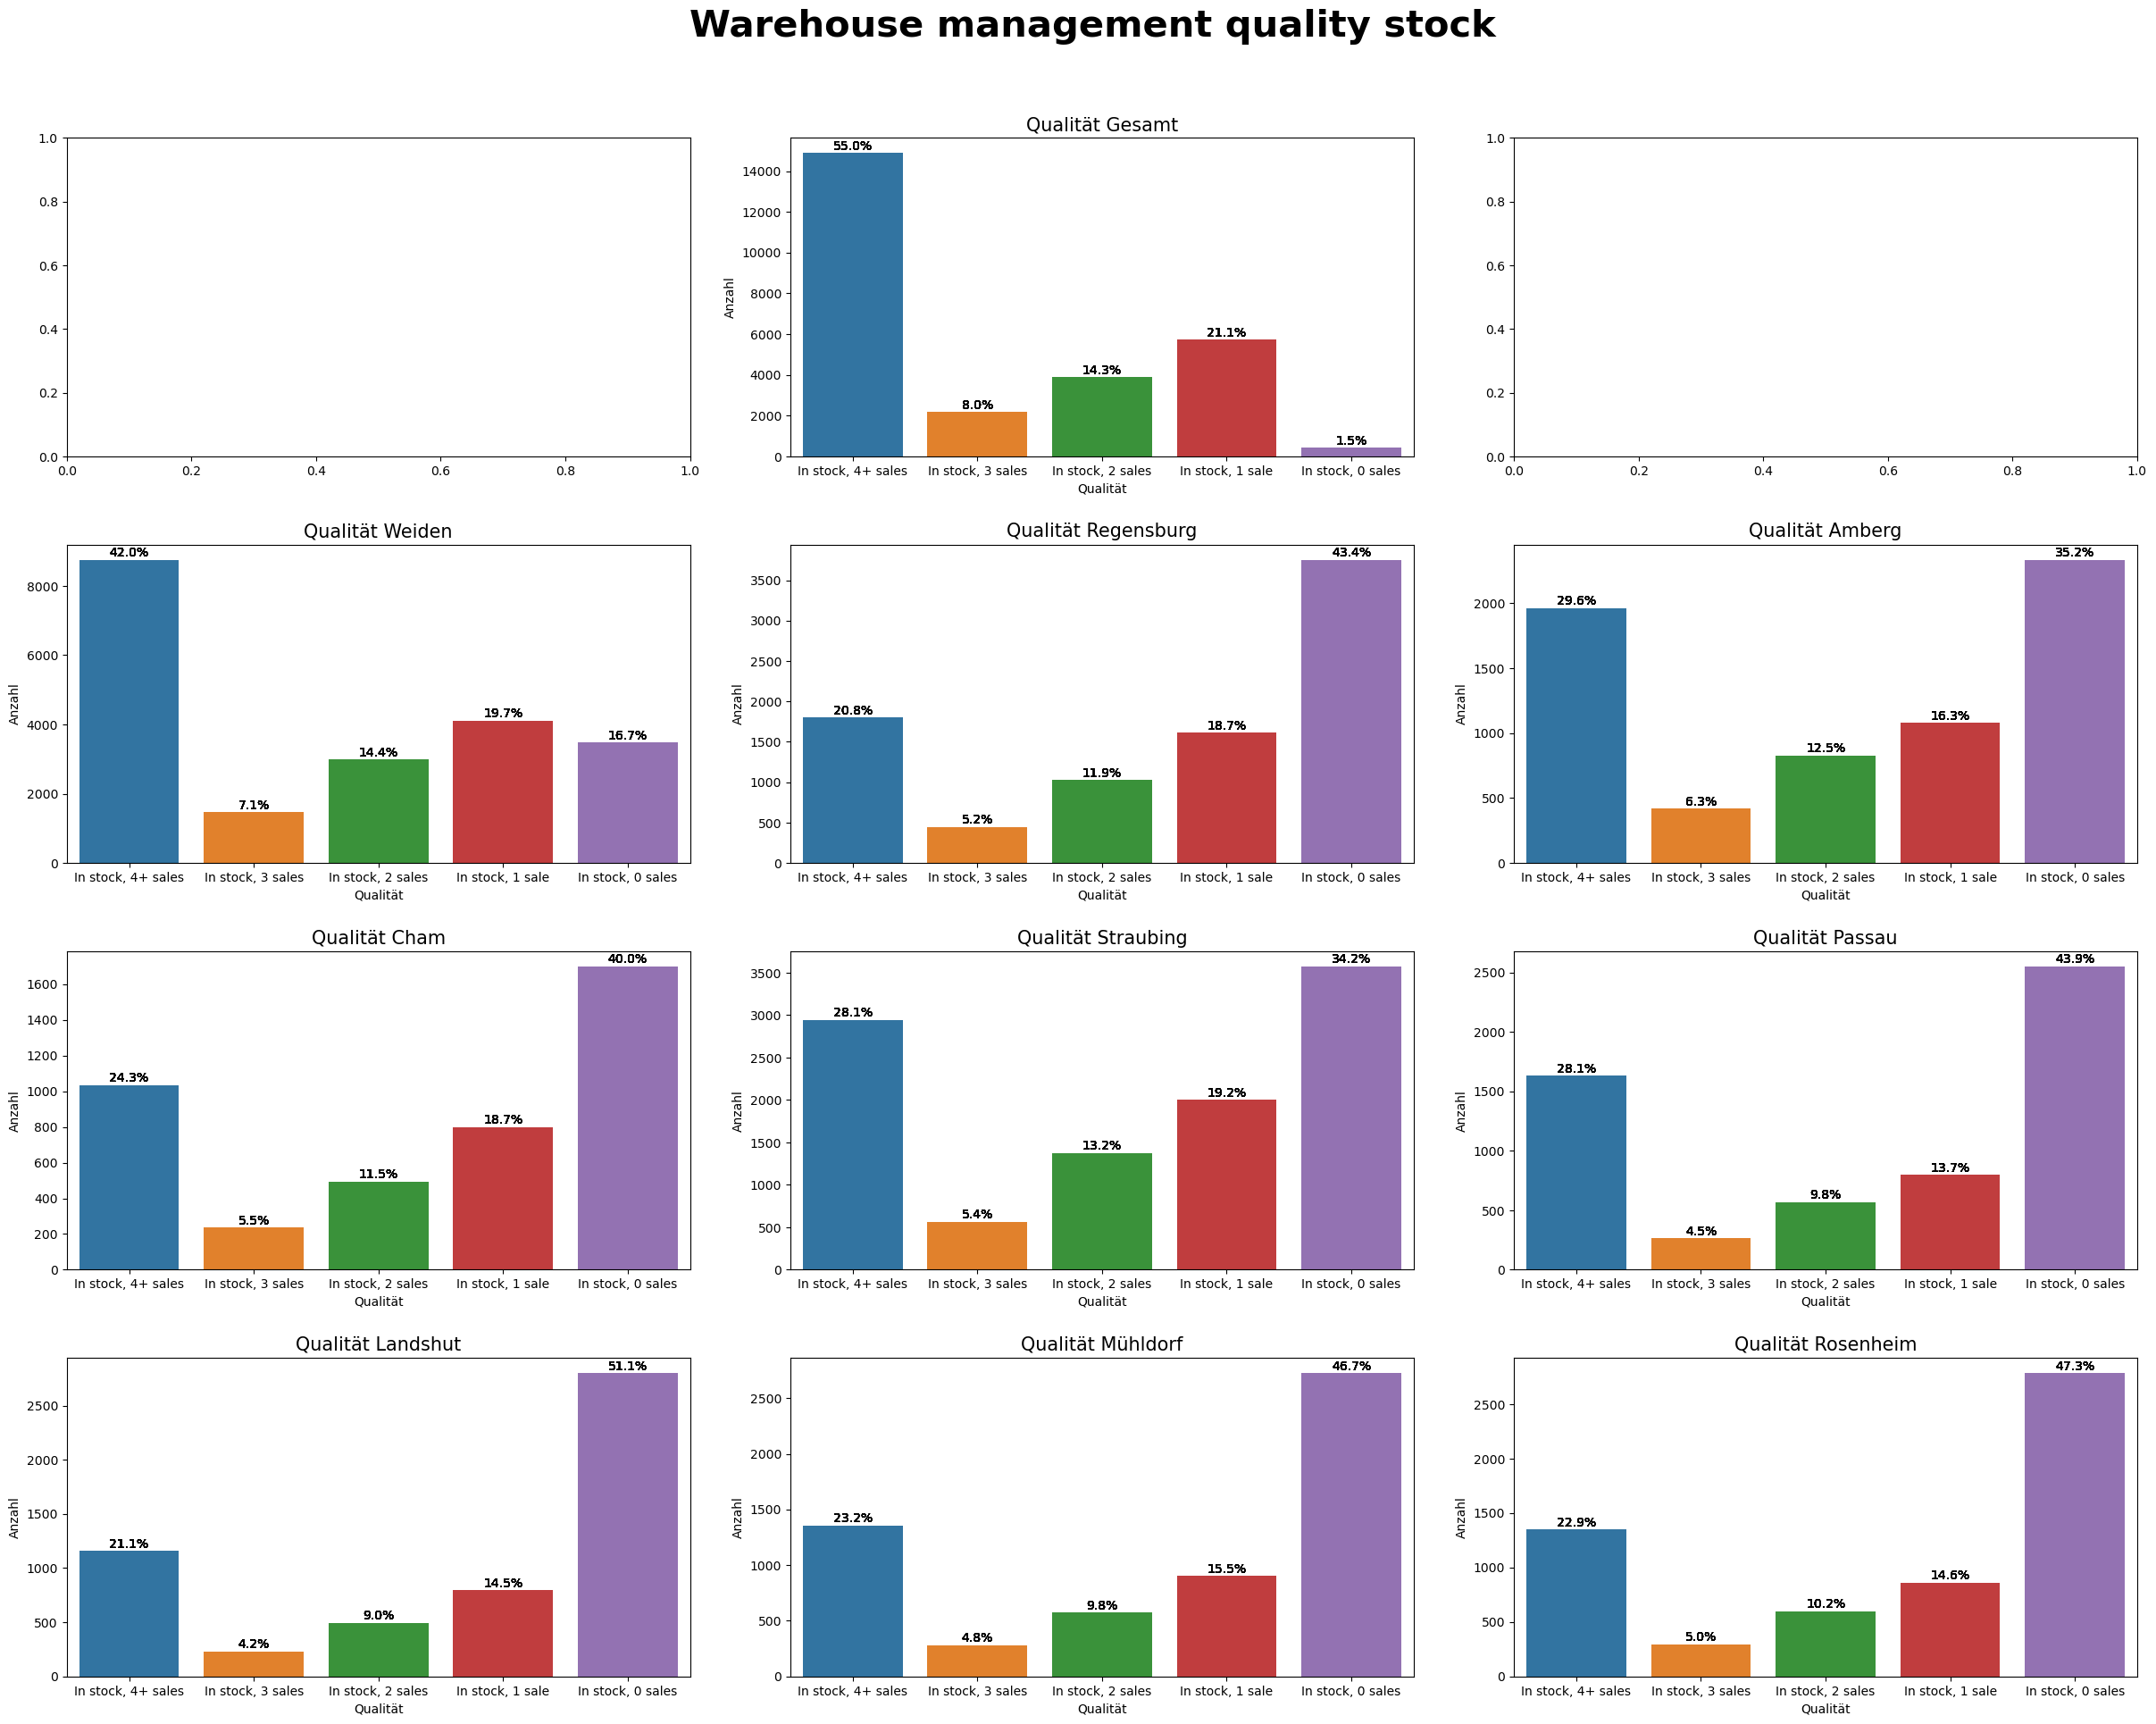

In [ ]:
# Create a bar chart with subplots to display overall and subsidiary's number of articles in stock categorized into number of sales

# Set up key and value of the Küblbeck locations in a dictionary
locations = {'gesamt': 'Gesamt', 
             'wen': 'Weiden', 
             'rgb': 'Regensburg', 
             'amb': 'Amberg', 
             'cha': 'Cham', 
             'str': 'Straubing', 
             'pas': 'Passau', 
             'lan': 'Landshut', 
             'müh': 'Mühldorf', 
             'ros': 'Rosenheim'}

# Defining wahrehousequality standards
PE_categories = ['In stock, 4+ sales', 'In stock, 3 sales', 'In stock, 2 sales', 'In stock, 1 sale', 'In stock, 0 sales']
display_order_quality = PE_categories

for x in locations.keys():
    PE_condition = [
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] > 3),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] == 3),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] == 2),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] == 1),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] == 0)   
    ]

    df_master[x+'_quality'] = np.select(PE_condition, PE_categories)

#Plotting
fig, axes = plt.subplots(4, 3, figsize=(25,20))
fig.suptitle('Warehouse management quality stock', fontweight='bold', fontsize=30)
fig.tight_layout(pad=5.0)

for i in range (13):
    y = 0
    z = 1

    for key, value in locations.items():

        # Create new columns with the quality  
        location = df_master.query(key + '_quality != "0"')

        # Plot tables
        sub = sns.countplot(ax=axes[y, z], x=key + '_quality', data=location, order=display_order_quality)
        axes[y, z].set_title("Qualität " + value, fontsize=15.0)
        axes[y, z].set_xlabel('Qualität', fontsize=10.0)
        axes[y, z].set_ylabel('Anzahl', fontsize=10.0)
        
        total = location[key + '_quality'].count()

        freq_series = location[key + '_quality'].value_counts()
        freq_series = freq_series.reindex(display_order_quality)

        rects = sub.patches
        labels = [f'{(x/total)*100:.1f}%' for x in freq_series]
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            axes[y, z].text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                    ha='center', va='bottom')
            
        z += 1  
        if y == 0 and z == 2:
            y = 1
            z = 0
            
        elif z >= 3:
            y += 1
            z = 0


## Visualize quality sales

In [ ]:
# Create a bar chart with subplots to display overall and subsidiary's number of articles categorized into number of sales and if in or out of stock 
# Set up key and value of the Küblbeck locations in a dictionary
locations = {'gesamt': 'Gesamt', 
             'wen': 'Weiden', 
             'rgb': 'Regensburg', 
             'amb': 'Amberg', 
             'cha': 'Cham', 
             'str': 'Straubing', 
             'pas': 'Passau', 
             'lan': 'Landshut', 
             'müh': 'Mühldorf', 
             'ros': 'Rosenheim'}

# Defining wahrehousequality standards
PE_categories = ['4+ sales, in stock', '4+ sales, no stock', '1-3 sales, in stock', '1-3 sales, no stock', '0 sales, in stock']
display_order_quality = PE_categories

for x in locations.keys():
    PE_condition = [
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] > 3),
        (df_master[x+'_lager'] == 0) & (df_master[x+'_vk'] > 3),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] < 3) & (df_master[x+'_vk'] > 0),
        (df_master[x+'_lager'] == 0) & (df_master[x+'_vk'] < 3) & (df_master[x+'_vk'] > 0),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] == 0)
    ]

    df_master[x+'_quality'] = np.select(PE_condition, PE_categories)

#Plotting
fig, axes = plt.subplots(4, 3, figsize=(25,20))
fig.suptitle('Warehouse management quality sales', fontweight='bold', fontsize=30)
fig.tight_layout(pad=5.0)

for i in range (13):
    y = 0
    z = 1

    for key, value in locations.items():

        # Create new columns with the quality    
        location = df_master.query(key + '_quality != "0"').reset_index()

        # Plot tables
        sub = sns.countplot(ax=axes[y, z], x=key + '_quality', data=location, order=display_order_quality)
        axes[y, z].set_title("Qualität " + value, fontsize=15.0)
        axes[y, z].set_xlabel('Qualität', fontsize=10.0)
        axes[y, z].set_ylabel('Anzahl', fontsize=10.0)
        total = location[key + '_quality'].count()

        freq_series = location[key + '_quality'].value_counts()
        freq_series = freq_series.reindex(display_order_quality)

        rects = sub.patches
        labels = [f'{(x/total)*100:.1f}%' for x in freq_series]
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            axes[y, z].text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                    ha='center', va='bottom')
            
        z += 1  
        if y == 0 and z == 2:
            y = 1
            z = 0
            
        elif z >= 3:
            y += 1
            z = 0


# Preparing Distribution Method

In [ ]:
df_master_quality = df_master.query('gesamt_quality != "0"')

# Set up key and value of the Küblbeck locations in a dictionary
locations = {'wen': 'Weiden', 
             'rgb': 'Regensburg', 
             'amb': 'Amberg', 
             'cha': 'Cham', 
             'str': 'Straubing', 
             'pas': 'Passau', 
             'lan': 'Landshut', 
             'müh': 'Mühldorf', 
             'ros': 'Rosenheim'}

# Defining wahrehousequality standards
PE_categories = ['4+ sales, in stock', '4+ sales, no stock', '1-3 sales, in stock', '1-3 sales, no stock', '0 sales, in stock']
display_order_quality = PE_categories

for x in locations.keys():
    PE_condition = [
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] > 3),
        (df_master[x+'_lager'] == 0) & (df_master[x+'_vk'] > 3),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] < 3) & (df_master[x+'_vk'] > 0),
        (df_master[x+'_lager'] == 0) & (df_master[x+'_vk'] < 3) & (df_master[x+'_vk'] > 0),
        (df_master[x+'_lager'] > 0) & (df_master[x+'_vk'] == 0)
    ]

    df_master[x+'_quality'] = np.select(PE_condition, PE_categories)

# Create new columns with the quality
for key, value in locations.items():
    df_master_quality['take_from_' + key] = df_master_quality.apply(lambda row: ', '.join([k for k, v in locations.items() if row[k + '_quality'] == '4+ sales, no stock']) if row[key + '_quality'] in ['1-3 sales, in stock', '0 sales, in stock'] else '-', axis=1)

df_master_quality_final = df_master_quality[~(df_master_quality.filter(like='take_from_').isin(['-', ''])).all(axis=1)]

NameError: name 'df_master' is not defined

# Code for Distribution Method


In [ ]:
df_master_quality_distribution = df_master_quality_final

# Count how many locations should get Items
def count_list_elements(x):
    if x == ['-']:
        return 0
    else:
        return len(x)

# Find out the location with the best sales and 0 Stock
def best_sale(row):
    a = row['list']
    if a == ['-']:
        return '-'
    else:
        best_sales = sorted([row[k + '_vk'] for k in row['list'] if k != '-' and k + '_vk' in row.index and row[k + '_vk'] is not None], key=lambda y: float(y) if isinstance(y, str) else y, reverse=True)[0]
        for i in row['list']:
            if row[i + '_vk'] == best_sales:
                return i
    
# Give back the numbers of Items a location should get
def assigning(row):
    a = row['list']
    b = row['dividing']
    c = row['remainder']
    d = row['best_sales']
    result = [f"{x} ({b + c:.0f})" if x == d else f"{x} ({b:.0f})" for x in a]
    return result

# Calculate the combined stock of all locations that should give items       
def calculate_stock(row):
    total_stock = 0
    pattern = r'\(\d+\)'
    for key in locations.keys():
        if isinstance(row['take_from_' + key], str) and row['take_from_' + key] != '-':
            matches = re.findall(pattern, row['take_from_' + key])
            for match in matches:
                stock = int(match[1:-1])
                total_stock += stock
    #total_stock *= row['basispreis']
    return total_stock

# Change abbreviation of the locations to full location names
def renaming(row, key):
    pattern = '|'.join(locations.keys())
    a = row['take_from_' + key]
    p = pattern
    res = re.sub(pattern, lambda match: locations[match.group(0)], a)
    return res

# Format the output and make a new line after every location
def formating(row, key):
    a = row['take_from_' + key]
    res_blank = a.replace(',', ',\n')
    #res_double = a.replace(') (', ',)""')
    return res_blank

# Create the table
for key, value in locations.items():
    df_master_quality_distribution['list'] = df_master_quality_distribution['take_from_' + key].apply(lambda x: [i for i in x.split(', ')])
    df_master_quality_distribution['numbers'] = df_master_quality_distribution['list'].apply(count_list_elements)
    df_master_quality_distribution['dividing'] = (df_master_quality_distribution[key +'_lager']/df_master_quality_distribution['numbers']).apply(np.floor)
    df_master_quality_distribution['remainder'] = (df_master_quality_distribution[key + '_lager']%df_master_quality_distribution['numbers'])
    df_master_quality_distribution['best_sales'] = df_master_quality_distribution.apply(best_sale, axis=1)
    df_master_quality_distribution['locations'] = df_master_quality_distribution.apply(assigning, axis=1)
    df_master_quality_distribution['locations'] = [','.join(map(str, l)) for l in df_master_quality_distribution['locations']]
    df_master_quality_distribution['locations'] = df_master_quality_distribution['locations'].replace(["- (nan)", "- (inf)", "- (-inf)"], "-")
    df_master_quality_distribution['take_from_' + key] = df_master_quality_distribution['locations']
    df_master_quality_distribution['take_from_' + key] = df_master_quality_distribution.apply(renaming, axis=1, key=key)
    df_master_quality_distribution['take_from_' + key] = df_master_quality_distribution.apply(formating, axis=1, key=key)
    df_master_quality_distribution['stock'] = df_master_quality_distribution.apply(calculate_stock, axis=1)

# Cleaning and Sorting

In [ ]:
# Function to keep columns we need instead of dropping columns we don't need
def keep_cols(DataFrame, keep_these):
    """Keep only the columns [keep_these] in a DataFrame, delete
    all other columns. 
    """
    drop_these = list(set(list(DataFrame)) - set(keep_these))
    return DataFrame.drop(drop_these, axis = 1)

# Define columns we want to keep
take_from = ['lieferant', 'artnr', 'beschreibung', 'lfnr', 'stock']
for key in locations.keys():
    a = f'take_from_{key}'
    take_from.append(a)

# Prepare everything for the output
df_master_quality_distribution.sort_values(by='stock', ascending=False, inplace=True)
df_master_quality_distribution.reset_index(inplace=True, drop=True)
df_master_quality_output = df_master_quality_distribution.pipe(keep_cols, take_from)

# Printing result

In [ ]:
# Style the output
df_master_quality_output.style